<a href="https://colab.research.google.com/github/dsirtioglu/python/blob/dsirtioglu-RR/Stocks_Prediciton_using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Predicting stock prices using Recurrent Neural Networks

# Install packages and import relevant libraries
!pip install yfinance
!pip install yahoofinancials

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

import yfinance as yf
from yahoofinancials import YahooFinancials

     |████████████████████████████████| 6.3MB 33.6MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23455 sha256=8076a88419ce7a565a7ca6c123de70c70456ec68591c0d41295a99ee597cbbee
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
  Created wheel for yahoofinancials: filename=yahoofinancials-1.6-cp37-none-any.whl size=15192 sha256=581176e74d0a020c2ac5d06f28f5bf8c26cb8592e9df9befce06712aa81dcef6
  Stored in directory: /root/.cache/pip/wheels/d9/7e/cf/4977a8572d5247242a4b13018d1d36923024ba84236e0d28bc
Successfully built yahoofinancials


In [2]:
# Load data

company = 'FB' #Facebook
McD = 'MCD' #McDonald's

start = dt.datetime(2008,1,1)
end = dt.datetime(2021,1,1)

data = web.DataReader(McD, 'yahoo', start, end)
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2008-01-02,59.480000,57.889999,59.480000,58.099998,7858300.0,39.046745
2008-01-03,58.799999,57.740002,58.400002,57.930000,6514700.0,38.932507
2008-01-04,57.470001,56.430000,57.330002,57.049999,9687500.0,38.341091
2008-01-07,58.250000,56.869999,57.360001,58.029999,10784500.0,38.999710
2008-01-08,58.639999,56.959999,58.439999,57.080002,10080800.0,38.361263


In [3]:
# Prepare Data

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Low'].values.reshape(-1,1))
scaled_data

array([[0.0659904 ],
       [0.06517235],
       [0.05802792],
       ...,
       [0.90892235],
       [0.90254147],
       [0.8998146 ]])

In [4]:
prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
  x_train.append(scaled_data[x-prediction_days:x, 0])
  y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [5]:
# Build the model

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) #Prediction of the next closing price

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)


Epoch 1/25
101/101 [==============================] - 13s 82ms/step - loss: 0.0136
Epoch 2/25
101/101 [==============================] - 9s 85ms/step - loss: 0.0028
Epoch 3/25
101/101 [==============================] - 8s 83ms/step - loss: 0.0026
Epoch 4/25
101/101 [==============================] - 9s 85ms/step - loss: 0.0024
Epoch 5/25
101/101 [==============================] - 9s 85ms/step - loss: 0.0025
Epoch 6/25
101/101 [==============================] - 8s 84ms/step - loss: 0.0021
Epoch 7/25
101/101 [==============================] - 8s 83ms/step - loss: 0.0020
Epoch 8/25
101/101 [==============================] - 8s 82ms/step - loss: 0.0017
Epoch 9/25
101/101 [==============================] - 8s 82ms/step - loss: 0.0017
Epoch 10/25
101/101 [==============================] - 8s 82ms/step - loss: 0.0017
Epoch 11/25
101/101 [==============================] - 8s 81ms/step - loss: 0.0020
Epoch 12/25
101/101 [==============================] - 8s 81ms/step - loss: 0.0014
Epoch 13/25


In [6]:
# Test The Model Accuracy on Existing Data

# Load Test Data
test_start = dt.datetime(2021,1,1)
test_end = dt.datetime.now()

test_data = web.DataReader(McD, 'yahoo', test_start, test_end)
actual_prices = test_data['Low'].values

total_dataset = pd.concat((data['Low'], test_data['Low']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

In [7]:
# Make predictions on Test Data

x_test = []

for x in range(prediction_days, len(model_inputs)):
  x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

In [8]:
# Output Dataframe actual vs. predicted prices

Output = pd.DataFrame(data = actual_prices, columns= ['actual_prices'])
Output['predicted_prices'] = predicted_prices
Output['Dates'] = test_data.iloc[:,0:1].index
Output = Output.set_index('Dates')

Output

,actual_prices,predicted_prices
Dates,,
2021-01-04,208.220001,212.955841
2021-01-05,209.619995,212.681915
2021-01-06,209.029999,212.315903
2021-01-07,210.559998,211.894989
2021-01-08,212.229996,211.561279
...,...,...
2021-06-02,232.809998,231.560608
2021-06-03,230.149994,231.942963
2021-06-04,232.070007,232.105576


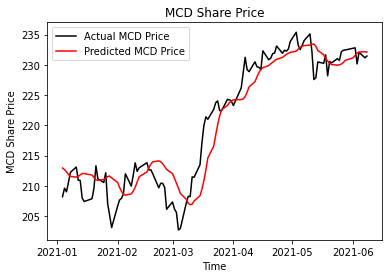

In [9]:
# Plot the Test Predictions
 
plt.plot(Output['actual_prices'], color = "black", label=f"Actual {McD} Price")
plt.plot(Output['predicted_prices'], color = "red", label=f"Predicted {McD} Price")
plt.title(f"{McD} Share Price")
plt.xlabel('Time')
plt.ylabel(f'{McD} Share Price')
plt.legend()
plt.show()

In [10]:
# Price Prediction next day

real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs+1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"The model predicts the Low value for the McD shares to be {prediction} tomorrow")

The model predicts the Low value for the McD shares to be [[231.99898]] tomorrow
